In [21]:
import os
import boto3
import pyart
import pytz
import geopandas
import numpy as np
import pandas as pd
import xarray as xr
import cartopy as crs
import cartopy.crs as ccrs
from pyart.config import get_metadata
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [22]:
s3 = boto3.client("s3")
Bucket = "s3-radaresideam"
Prefijo = "l2_data/2023/05/27/santa_elena"

paginator = s3.get_paginator("list_objects_v2")
contenido = []
for page in paginator.paginate(Bucket = Bucket, Prefix = Prefijo):
    contenido.extend(page["Contents"])
contenido = pd.DataFrame(contenido)
contenido.LastModified = contenido.LastModified - timedelta(hours = 5)

In [23]:
Key = contenido[contenido.LastModified >= datetime(2023, 5, 27, 15, 17, tzinfo=pytz.utc)].iloc[9].Key
s3.download_file(Bucket = Bucket, Key = Key, Filename = f"imagenes_lluvia/{Key.split('/')[-1]}")
name = Key.split("/")[-1]

In [36]:
dataset = xr.open_dataset(f'imagenes_lluvia/{Key.split("/")[-1]}', decode_times=False)
radar = pyart.testing.make_empty_ppi_radar(dataset.range.shape[0], dataset.azimuth.shape[0], 1)
radar.time["data"] = np.array(dataset["time"][:])
radar.elevation["data"] = dataset.elevation.values
radar.azimuth["data"] = dataset.azimuth.values
radar.range["data"]=dataset.range.values
radar.latitude["data"] = np.array([float(dataset.latitude.values)])
radar.longitude["data"] = np.array([float(dataset.longitude.values)])
radar.sweep_number["data"] = np.array(dataset["sweep"])
ref_dict = get_metadata("DBZH")
ref_dict["data"] = dataset.DBZH.values
radar.fields = {"DBZH": ref_dict}
fields=["DBZH"]
radar.fields["DBZH"]["data"] = np.where(radar.fields["DBZH"]["data"] > 0,radar.fields["DBZH"]["data"], np.nan)
display = pyart.graph.RadarMapDisplay(radar)

/home/juliosimonpedro/anaconda3/envs/pyart_env/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/juliosimonpedro/anaconda3/envs/pyart_env/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/juliosimonpedro/anaconda3/envs/pyart_env/lib/python3.10/site-packages/pyart/graph/radarmapdisplay.py:467: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  self.ax.plot(lon, lat, symbol, **kwargs)
/home/juliosimonpedro/anaconda3/envs/pyart_env/lib/python3.10/site-packages/pyart/graph/radarmapdisplay.py:467: Use

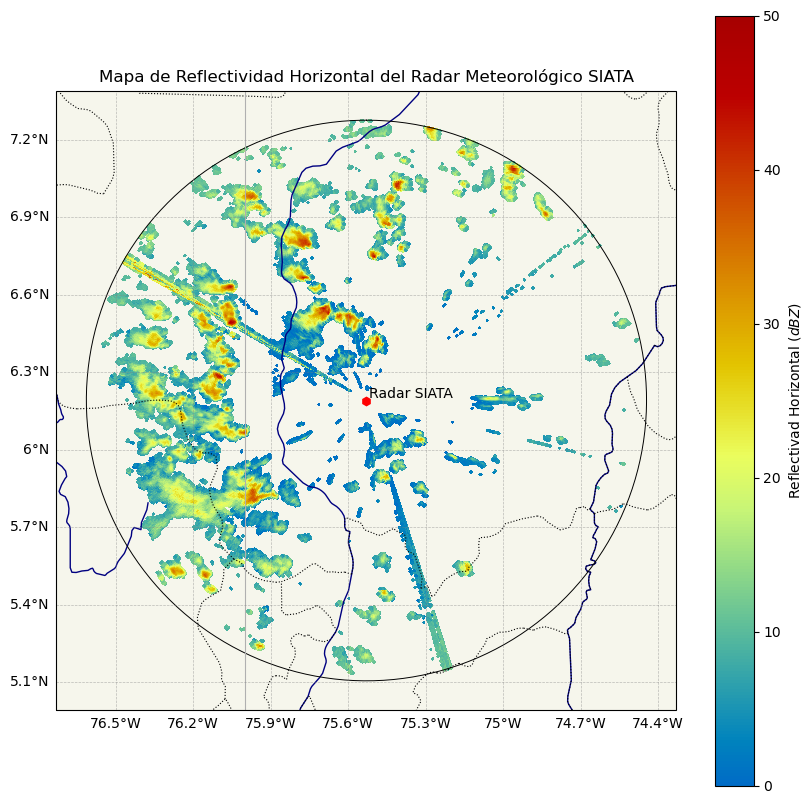

<Figure size 640x480 with 0 Axes>

In [39]:
projection = ccrs.PlateCarree(
        central_longitude = radar.longitude["data"][0])

fig = plt.figure(figsize = (10,10))
display.plot_ppi_map(
                "DBZH", 
                vmin = 0, vmax = 50, 
                projection = projection,
                colorbar_label="Reflectivad Horizontal ($dBZ$)")

lon = dataset.longitude.values
lat = dataset.latitude.values
valor_aum = 1.2
ax = plt.gca()
ax.set_extent([lon-valor_aum, lon+valor_aum, lat-valor_aum, lat+valor_aum], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
display.plot_point(lon, lat, color = "red", marker = "h", linewidth = 3, label_text = "Radar SIATA")
display.plot_range_ring(120.0, line_style="dot", linewidth = 0.7)

ax.add_feature(crs.feature.RIVERS, linewidth = 1, color = "navy")
ax.add_feature(crs.feature.NaturalEarthFeature("cultural", "admin_1_states_provinces_lines", "10m", facecolor = "none"), 
                alpha = 1, linestyle = "dotted", linewidth = 0.8)
ax.add_feature(crs.feature.LAND, alpha = 0.5)
plt.title("Mapa de Reflectividad Horizontal del Radar Meteorológico SIATA")

plt.show()
plt.savefig("mapa_introduccion.png")

In [26]:
def polar_cartesian(
        range,
        azimuth,
        elevation):
    elevation = np.deg2rad(elevation)
    azimuth = np.deg2rad(azimuth)
    R = 6371 * 1000 * (4/3) #Radio de la tierra efectivo en metros
    z = np.sqrt(range**2 + R**2 + 2 * range * R * np.sin(elevation)) - R
    S = R * np.arctan((range * np.cos(elevation))/(R + z))
    x = S * np.sin(azimuth)
    y = S * np.cos(azimuth)
    return x , y , z 

In [27]:
ax.get_yticks()

[0]

In [28]:
dataset.range.values[0]

62.5

In [29]:
4/3

1.3333333333333333

In [30]:
grid=pyart.map.grid_from_radars(
radar,
grid_shape=(1,1000, 1000),
grid_limits=((0,10000), (-300000, 300000), (-300000, 300000)),
fields=fields
)

pyart.io.write_grid(
grid=grid,
filename=f"imagenes_lluvia/prueba.nc",
include_fields=fields[0],
format="NETCDF4"
)